# REDFIN MODEL MONITORING: AAI-540-MLOps

In [1]:
import boto3
import IPython
import sagemaker
import sys

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
print(sagemaker.get_execution_role())

arn:aws:iam::467784391554:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


# Organize imports

In [3]:
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler
from sagemaker.inputs import TrainingInput
from sagemaker.model_monitor import CronExpressionGenerator
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.model_monitor.model_monitoring import EndpointInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import datetime
import random

# Create common objects

In [4]:
# Specify the S3 bucket name
s3_bucket = 'march2modelmonitor'

# Create the S3 Boto3 resource
s3_resource = boto3.resource('s3')
s3_bucket_resource = s3_resource.Bucket(s3_bucket)

# Create the SageMaker Boto3 client
sm_client = boto3.client('sagemaker')

# Base name to be used to create resources
nb_name = 'redfin-xgboost-housing-monitor-alert'

# Names of various resources
train_job_name = 'train-{}'.format(nb_name)
model_name = 'model-{}'.format(nb_name)
endpoint_name = 'endpt-{}'.format(nb_name)
dq_base_job_name = 'dq-{}'.format(nb_name)
mq_base_job_name = 'mq-{}'.format(nb_name)
dq_baseline_job_name_prefix = 'dq-bsl-job-{}'.format(nb_name)
mq_baseline_job_name_prefix = 'mq-bsl-job-{}'.format(nb_name)
dq_mon_schedule_name = 'dq-mon-sch-{}'.format(nb_name)
mq_mon_schedule_name = 'mq-mon-sch-{}'.format(nb_name)

# Names of local sub-directories in the notebook file system
data_dir = os.path.join(os.getcwd(), 'data/{}'.format(nb_name))
train_dir = os.path.join(os.getcwd(), 'data/{}/train'.format(nb_name))
val_dir = os.path.join(os.getcwd(), 'data/{}/validate'.format(nb_name))
test_dir = os.path.join(os.getcwd(), 'data/{}/test'.format(nb_name))
ground_truth_dir = os.path.join(os.getcwd(), 'data/{}/ground-truth'.format(nb_name))

# Location of the datasets file in the notebook file system
dataset_csv_file = os.path.join(os.getcwd(), 'datasets/REDFINMAR2.csv')

# Sub-folder names in S3
train_dir_s3_prefix = '{}/data/train'.format(nb_name)
val_dir_s3_prefix = '{}/data/validate'.format(nb_name)
test_dir_s3_prefix = '{}/data/test'.format(nb_name)
ground_truth_dir_s3_prefix = '{}/data/ground-truth'.format(nb_name)

# Location in S3 where the model checkpoint will be stored
model_checkpoint_s3_path = 's3://{}/{}/checkpoint/'.format(s3_bucket, nb_name)

# Location in S3 where the trained model will be stored
model_output_s3_path = 's3://{}/{}/output/'.format(s3_bucket, nb_name)

# Location in S3 that will contain all model monitor related files
model_monitor_s3_path = 's3://{}/{}/model-monitor'.format(s3_bucket, nb_name)

# Location in S3 where the data captured from the endpoint will be stored.
# Do not add a '/' at the end of the path here; it will be automatically added by the endpoint. If you add
# a '/' at the end, then the monitoring schedule will not be able to find the data capture files and your
# schedule will fail even if files are present in that S3 location.
data_capture_output_s3_path = '{}/data-capture'.format(model_monitor_s3_path)

# Location in S3 where the results from the baseline job will be stored
dq_baseline_job_output_s3_path = '{}/data-quality/baseline/'.format(model_monitor_s3_path)

# Location in S3 where the results from the baseline job will be stored
mq_baseline_job_output_s3_path = '{}/model-quality/baseline/'.format(model_monitor_s3_path)

# Location in S3 where the results from the monitoring job will be stored
# Do not add a '/' at the end of the path here
dq_mon_schedule_output_s3_path = '{}/data-quality/monitoring'.format(model_monitor_s3_path)

# Location in S3 where the results from the monitoring job will be stored
# Do not add a '/' at the end of the path here
mq_mon_schedule_output_s3_path = '{}/model-quality/monitoring'.format(model_monitor_s3_path)

# Set the inference id prefix to consistently use it when invoking the endpoint
# at various steps in this notebook
inference_id_prefix = 'FromNotebook_'

# Create the local directories

In [5]:
# Create the local directories
os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(ground_truth_dir, exist_ok=True)

# Load the dataset and view the details

In [6]:
# Check if the dataset file exists and proceed
if os.path.exists(dataset_csv_file):
    print('Dataset CSV file \'{}\' exists.'.format(dataset_csv_file))
    # Load the data into a Pandas DataFrame
    pd_data_frame = pd.read_csv(dataset_csv_file)
    # Print the first 5 records
    #print(pd_data_frame.head(5))
    # Describe the dataset
    print(pd_data_frame.describe())
else:
    print('Dataset CSV file \'{}\' does not exist.'.format(dataset_csv_file))

Dataset CSV file '/home/ec2-user/SageMaker/datasets/REDFINMAR2.csv' exists.
       median_sale_price  median_sale_price_yoy  median_list_price  \
count       5.310700e+04           53107.000000       5.310700e+04   
mean        2.934025e+05               0.176421       3.091523e+05   
std         4.178382e+05               3.299475       3.947308e+05   
min         1.000000e+00              -0.993043       4.975000e+02   
25%         1.335992e+05              -0.015479       1.499000e+05   
50%         2.100000e+05               0.078998       2.250000e+05   
75%         3.394090e+05               0.189769       3.490000e+05   
max         3.000000e+07             682.168317       1.950000e+07   

         homes_sold  homes_sold_yoy  new_listings  new_listings_yoy  \
count  53107.000000    53107.000000  53107.000000      53107.000000   
mean      37.111887        0.224933     44.798915          0.170379   
std       57.269616        1.607143     66.500914          3.772989   
min      

# Visualize the dataset

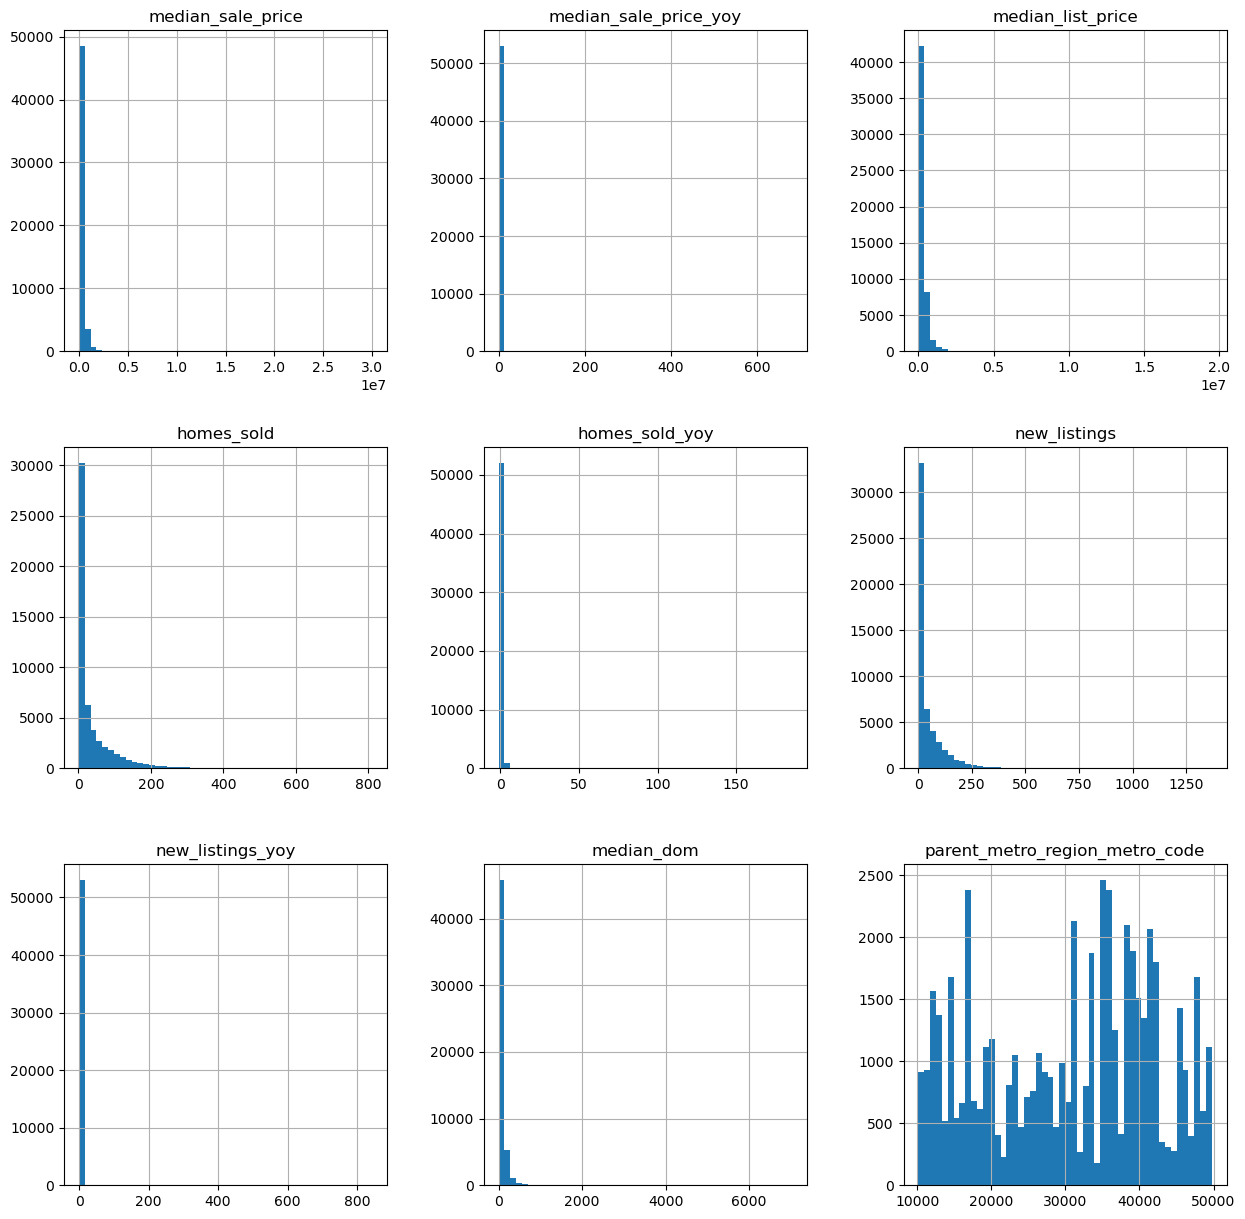

In [7]:
pd_data_frame.hist(bins=50, figsize=(15,15))
plt.show()

In [8]:
pd_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53107 entries, 0 to 53106
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   median_sale_price               53107 non-null  float64
 1   median_sale_price_yoy           53107 non-null  float64
 2   median_list_price               53107 non-null  float64
 3   homes_sold                      53107 non-null  float64
 4   homes_sold_yoy                  53107 non-null  float64
 5   new_listings                    53107 non-null  float64
 6   new_listings_yoy                53107 non-null  float64
 7   median_dom                      53107 non-null  float64
 8   parent_metro_region_metro_code  53107 non-null  float64
dtypes: float64(9)
memory usage: 3.6 MB


# Split the dataset into train, validate and test sets

Split the dataset into train, validate and test sets after shuffling. Split further into x and y sets.

'median_income,
housing_median_age,
total_rooms,
total_bedrooms,
population,
households,
latitude,
longitude'

In [9]:
# Split into train and test datasets after shuffling
train, test = sklearn.model_selection.train_test_split(pd_data_frame, test_size=0.2,
                                                       random_state=35, shuffle=True)
# Split the train dataset further into train and validation datasets after shuffling
train, val = sklearn.model_selection.train_test_split(train, test_size=0.1,
                                                      random_state=25, shuffle=True)

# Define functions to get x and y columns
def get_x(df):
    return df[['median_sale_price_yoy','median_list_price','homes_sold','homes_sold_yoy',
                 'new_listings','new_listings_yoy','median_dom','parent_metro_region_metro_code']]
def get_y(df):
    return df[['median_sale_price']]

# Load the x and y columns for train, validation and test datasets
x_train = get_x(train)
y_train = get_y(train)
x_val = get_x(val)
y_val = get_y(val)
x_test = get_x(test)
y_test = get_y(test)

# Summarize the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (38236, 8)
y_train shape: (38236, 1)
x_val shape: (4249, 8)
y_val shape: (4249, 1)
x_test shape: (10622, 8)
y_test shape: (10622, 1)


# Standardize the datasets

Standardize the x columns of the train dataset using the fit_transform() function of StandardScaler.

Standardize the x columns of the validate and test datasets using the transform() function of StandardScaler.

In [10]:
# Standardize the dataset
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Save the prepared datasets locally

headers = ','.join(['median_sale_price_yoy', 'median_list_price', 'homes_sold', 'homes_sold_yoy', 'new_listings', 'new_listings_yoy', 'median_dom', 'parent_metro_region_metro_code'])
create_file_with_header(os.path.join(train_dir, 'train_x.csv'), os.path.join(train_dir, 'train_x_with_header.csv'), headers)


In [11]:
# Define function to prepend header and create the specified new file
def create_file_with_header(src_file_full_path, tgt_file_full_path, header):
    with open(src_file_full_path, 'rt') as src_file, open(tgt_file_full_path, 'wt') as tgt_file:
        tgt_file.write(header + '\n')
        for src_line in src_file:
            tgt_file.write(src_line)

# Save the prepared dataset (in numpy format) to the local directories as csv files
np.savetxt(os.path.join(train_dir, 'train.csv'),
           np.concatenate((y_train.to_numpy(), x_train), axis=1), delimiter=',')
np.savetxt(os.path.join(train_dir, 'train_x.csv'), x_train)
headers = ','.join(['median_sale_price_yoy', 'median_list_price', 'homes_sold', 'homes_sold_yoy', 'new_listings', 'new_listings_yoy', 'median_dom', 'parent_metro_region_metro_code'])
create_file_with_header(os.path.join(train_dir, 'train_x.csv'), os.path.join(train_dir, 'train_x_with_header.csv'), headers)
np.savetxt(os.path.join(train_dir, 'train_y.csv'), y_train.to_numpy())

np.savetxt(os.path.join(val_dir, 'validate.csv'),
           np.concatenate((y_val.to_numpy(), x_val), axis=1), delimiter=',')
np.savetxt(os.path.join(val_dir, 'validate_x.csv'), x_val)
np.savetxt(os.path.join(val_dir, 'validate_y.csv'), y_val.to_numpy())

np.savetxt(os.path.join(test_dir, 'test.csv'),
           np.concatenate((y_test.to_numpy(), x_test), axis=1), delimiter=',')
np.savetxt(os.path.join(test_dir, 'test_x.csv'), x_test)
np.savetxt(os.path.join(test_dir, 'test_y.csv'), y_test.to_numpy())

# Upload the prepared datasets to S3

In [12]:
# Upload the data to S3
train_dir_s3_path = sagemaker.Session().upload_data(path='./data/{}/train/'.format(nb_name),
                                                          bucket=s3_bucket,
                                                          key_prefix=train_dir_s3_prefix)
val_dir_s3_path = sagemaker.Session().upload_data(path='./data/{}/validate/'.format(nb_name),
                                                        bucket=s3_bucket,
                                                        key_prefix=val_dir_s3_prefix)
test_dir_s3_path = sagemaker.Session().upload_data(path='./data/{}/test/'.format(nb_name),
                                                         bucket=s3_bucket,
                                                         key_prefix=test_dir_s3_prefix)

# Capture the S3 locations for the uploaded datasets
train_s3_path = '{}/train.csv'.format(train_dir_s3_path)
train_x_s3_path = '{}/train_x.csv'.format(train_dir_s3_path)
train_y_s3_path = '{}/train_y.csv'.format(train_dir_s3_path)
train_x_with_header_s3_path = '{}/train_x_with_header.csv'.format(train_dir_s3_path)
val_s3_path = '{}/validate.csv'.format(val_dir_s3_path)
val_x_s3_path = '{}/validate_x.csv'.format(val_dir_s3_path)
val_y_s3_path = '{}/validate_y.csv'.format(val_dir_s3_path)
test_s3_path = '{}/test.csv'.format(test_dir_s3_path)
test_x_s3_path = '{}/test_x.csv'.format(test_dir_s3_path)
test_y_s3_path = '{}/test_y.csv'.format(test_dir_s3_path)

# Perform training

In [13]:
# Set the input data input along with their content types
train_input = TrainingInput(train_s3_path, content_type='text/csv')
inputs = {'train':train_input}

# Set the hyperparameters
hyperparameters = {
        'objective':'reg:squarederror',
        'max_depth':'6',
        'eta':'0.3',
        'alpha':'3',
        'colsample_bytree':'0.7',
        'num_round':'100'}

# Set the instance count, instance type, volume size, options to use Spot instances and other parameters
train_instance_count = 1
train_instance_type = 'ml.m5.xlarge'
train_instance_volume_size_in_gb = 5
#use_spot_instances = True
#spot_max_wait_time_in_seconds = 5400
use_spot_instances = False
spot_max_wait_time_in_seconds = None
max_run_time_in_seconds = 3600
region_name = sagemaker.Session().boto_region_name
algorithm_name = 'xgboost'
algorithm_version = '1.2-1'
py_version = 'py37'
# Get the container image URI for the specified parameters
container_image_uri = sagemaker.image_uris.retrieve(framework=algorithm_name,
                                                    region=region_name,
                                                    version=algorithm_version,
                                                    py_version=py_version,
                                                    instance_type=train_instance_type,
                                                    image_scope='training')

# Set the training container related parameters
container_log_level = logging.INFO

# Location where the model checkpoints will be stored locally in the container before being uploaded to S3
model_checkpoint_local_dir = '/opt/ml/checkpoints/'

# Location where the trained model will be stored locally in the container before being uploaded to S3
model_local_dir = '/opt/ml/model'

# Run the training job

In [14]:
# Create the estimator
estimator = sagemaker.estimator.Estimator(
    image_uri=container_image_uri,
    checkpoint_local_path=model_checkpoint_local_dir,
    checkpoint_s3_uri=model_checkpoint_s3_path,
    model_dir=model_local_dir,
    output_path=model_output_s3_path,
    instance_type=train_instance_type,
    instance_count=train_instance_count,
    use_spot_instances=use_spot_instances,
    max_wait=spot_max_wait_time_in_seconds,
    max_run=max_run_time_in_seconds,
    hyperparameters=hyperparameters,
    role=sagemaker.get_execution_role(),
    base_job_name=train_job_name,
    framework_version=algorithm_version,
    py_version=py_version,
    container_log_level=container_log_level,
    script_mode=False,
    debugger_hook_config=False,
    disable_profiler=True)

# Perform the training
estimator.fit(inputs, wait=True)

INFO:sagemaker:Creating training-job with name: train-redfin-xgboost-housing-monitor-al-2024-03-03-15-06-46-845


2024-03-03 15:06:47 Starting - Starting the training job...
2024-03-03 15:07:01 Starting - Preparing the instances for training...
2024-03-03 15:07:35 Downloading - Downloading input data...
2024-03-03 15:07:55 Downloading - Downloading the training image...
2024-03-03 15:08:30 Training - Training image download completed. Training in progress.[2024-03-03 15:08:40.329 ip-10-2-223-27.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
INFO:root:Train matrix has 38236 rows and 8 

# Perform deployment

A) Set the deployment parameters
Deployment instance details:

Instance count

Instance type

The Elastic Inference accelerator type

Serializer and deserializer - set them to CSV as the data will be in CSV format.

In [16]:
# Set the instance count, instance type, endpoint name and other parameters
deploy_initial_instance_count = 1
deploy_instance_type = 'ml.m5.xlarge'
accelerator_type = None
serializer = CSVSerializer(content_type='text/csv')
deserializer = CSVDeserializer(encoding='utf-8', accept='text/csv')

# Set the deployment parameters
1. Deployment instance details:

a. Instance count

b. Instance type

c. The Elastic Inference accelerator type

2. Serializer and deserializer - set them to CSV as the data will be in CSV format.

In [17]:
# Set the instance count, instance type, endpoint name and other parameters
deploy_initial_instance_count = 1
deploy_instance_type = 'ml.m5.xlarge'
accelerator_type = None
serializer = CSVSerializer(content_type='text/csv')
deserializer = CSVDeserializer(encoding='utf-8', accept='text/csv')

# Set the data capture parameters

In [18]:
# Set the data capture configuration
data_capture_config = DataCaptureConfig(
    enable_capture = True,
    sampling_percentage=100,
    destination_s3_uri=data_capture_output_s3_path,
    capture_options=['REQUEST', 'RESPONSE'],
    csv_content_types=['text/csv'],
    json_content_types=None,
    sagemaker_session=sagemaker.Session())

# (Optional) Delete previously deployed resources

# Delete the model, endpoint configuration and endpoint
endpoint_config_name = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointConfigName']
sm_client.delete_model(ModelName=model_name)
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# Deploy the model

In [20]:
# Deploy the model and automatically create the endpoint configuration in the process
predictor = estimator.deploy(initial_instance_count=deploy_initial_instance_count,
                             instance_type=deploy_instance_type,
                             accelerator_type=accelerator_type,
                             serializer=serializer,
                             deserializer=deserializer,
                             model_name=model_name,
                             endpoint_name=endpoint_name,
                             data_capture_config=data_capture_config,
                             wait=True)

INFO:sagemaker:Creating model with name: model-redfin-xgboost-housing-monitor-alert
INFO:sagemaker:Creating endpoint-config with name endpt-redfin-xgboost-housing-monitor-alert
INFO:sagemaker:Creating endpoint with name endpt-redfin-xgboost-housing-monitor-alert


-----!

# Create monitoring baselines

# A) Data Quality Monitor

Create the Data Quality Monitor

In [21]:
# Specify parameters
dq_instance_count = 1
dq_instance_type = 'ml.m5.xlarge'
dq_instance_volume_size_in_gb = 5
dq_max_run_time_in_seconds = 1800

# Create the Data Quality Monitor
dq_monitor = DefaultModelMonitor(
    role=sagemaker.get_execution_role(),
    instance_count=dq_instance_count,
    instance_type=dq_instance_type,
    volume_size_in_gb=dq_instance_volume_size_in_gb,
    max_runtime_in_seconds=dq_max_run_time_in_seconds,
    base_job_name=dq_base_job_name,
    sagemaker_session=sagemaker.Session()
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Generate the baseline

Create the baseline job for the monitor created in the previous step and generate constraints. This will create a Processing Job in SageMaker.

In [22]:
# Set the other parameters
dq_baseline_job_name = '{}-{:%Y%m%d%H%M}'.format(dq_baseline_job_name_prefix, datetime.datetime.now())
dq_baseline_dataset_format = DatasetFormat.csv(header=True, output_columns_position='START')

# Create the baseline job and generate the constraints
dq_monitor.suggest_baseline(
    job_name=dq_baseline_job_name,
    baseline_dataset=train_x_with_header_s3_path,
    dataset_format=dq_baseline_dataset_format,
    output_s3_uri=dq_baseline_job_output_s3_path,
    wait=True,
    logs=True
)

INFO:sagemaker:Creating processing-job with name dq-bsl-job-redfin-xgboost-housing-monitor-alert-202403031525


..........................2024-03-03 15:30:08.812236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-03 15:30:08.812274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-03 15:30:10.448601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-03 15:30:10.448633: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-03 15:30:10.448656: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-2-71-87.ec2.internal): /proc/driver/nvidia/version does not exist
2024-03-03 15:30:10.4489

# Display the generated baseline

In [23]:
# Get the latest baselining job
dq_baseline_job = dq_monitor.latest_baselining_job

# Print the statistics
print('\nData Quality statistics:\n')
print(dq_baseline_job.baseline_statistics().body_dict['features'])

# Print the constraints
print('\nData Quality constraints:\n')
print(dq_baseline_job.suggested_constraints().body_dict['features'])

# Print the monitoring config
print('\nData Quality monitoring config:\n')
print(dq_baseline_job.suggested_constraints().body_dict['monitoring_config'])


Data Quality statistics:

[{'name': 'median_sale_price_yoy', 'inferred_type': 'String', 'string_statistics': {'common': {'num_present': 38236, 'num_missing': 0}, 'distinct_count': 41247.0}}, {'name': 'median_list_price', 'inferred_type': 'Unknown'}, {'name': 'homes_sold', 'inferred_type': 'Unknown'}, {'name': 'homes_sold_yoy', 'inferred_type': 'Unknown'}, {'name': 'new_listings', 'inferred_type': 'Unknown'}, {'name': 'new_listings_yoy', 'inferred_type': 'Unknown'}, {'name': 'median_dom', 'inferred_type': 'Unknown'}, {'name': 'parent_metro_region_metro_code', 'inferred_type': 'Unknown'}]

Data Quality constraints:

[{'name': 'median_sale_price_yoy', 'inferred_type': 'String', 'completeness': 1.0}, {'name': 'median_list_price', 'inferred_type': 'Unknown', 'completeness': 0.0}, {'name': 'homes_sold', 'inferred_type': 'Unknown', 'completeness': 0.0}, {'name': 'homes_sold_yoy', 'inferred_type': 'Unknown', 'completeness': 0.0}, {'name': 'new_listings', 'inferred_type': 'Unknown', 'completen

# B) Model Quality Monitor

# Prepare the dataset for baselining

In [24]:
# Iterate over the validate dataset and call the predictor for each row
predictions_labels_list = []
predictions_labels_list.append('prediction,label\n')
x_val_rows = x_val.tolist()
y_val_rows = y_val.to_numpy()
for index, x_val_row in enumerate(x_val_rows, start=1):
    x_val_row_string = ','.join(map(str, x_val_row))
    inference_id = '{}{}'.format(inference_id_prefix, index)
    predicted_object = predictor.predict(data=x_val_row_string,
                                         target_model=None,
                                         target_variant=None,
                                         inference_id=inference_id)
    predicted_value = float(predicted_object[0][0])
    predictions_labels_list.append('{},{}\n'.format(predicted_value, y_val_rows[index - 1][0]))

# Write the predictions-labels file to the local directory
predictions_labels_file_name = 'predictions_labels.csv'
predictions_labels_file_path = os.path.join(val_dir, predictions_labels_file_name)
with open(predictions_labels_file_path, 'wt') as predictions_labels_file:
    predictions_labels_file.write(''.join(predictions_labels_list))

# Upload the predictions-labels data to S3
predictions_labels_s3_path = sagemaker.Session().upload_data(path='./data/{}/validate/{}'.format(nb_name,
                                                                                            predictions_labels_file_name),
                                                        bucket=s3_bucket,
                                                        key_prefix=val_dir_s3_prefix)

# Create the Model Quality Monitor

In [25]:
# Specify parameters
mq_instance_count = 1
mq_instance_type = 'ml.m5.xlarge'
mq_instance_volume_size_in_gb = 5
mq_max_run_time_in_seconds = 1800

# Create the Model Quality Monitor
mq_monitor = ModelQualityMonitor(
    role=sagemaker.get_execution_role(),
    instance_count=mq_instance_count,
    instance_type=mq_instance_type,
    volume_size_in_gb=mq_instance_volume_size_in_gb,
    max_runtime_in_seconds=mq_max_run_time_in_seconds,
    base_job_name=mq_base_job_name,
    sagemaker_session=sagemaker.Session()
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


# Generate the baseline

In [26]:
# Set the other parameters
mq_baseline_job_name = '{}-{:%Y%m%d%H%M}'.format(mq_baseline_job_name_prefix, datetime.datetime.now())
mq_baseline_dataset_format = DatasetFormat.csv(header=True, output_columns_position='START')
mq_problem_type = 'Regression'
mq_inference_attribute = 'prediction'
mq_ground_truth_attribute = 'label'

# Create the baseline job and generate the constraints
mq_monitor.suggest_baseline(
    job_name=mq_baseline_job_name,
    baseline_dataset=predictions_labels_s3_path,
    dataset_format=mq_baseline_dataset_format,
    output_s3_uri=mq_baseline_job_output_s3_path,
    problem_type=mq_problem_type,
    inference_attribute=mq_inference_attribute,
    ground_truth_attribute=mq_ground_truth_attribute,
    wait=True,
    logs=True
)

INFO:sagemaker:Creating processing-job with name mq-bsl-job-redfin-xgboost-housing-monitor-alert-202403031542


..........................2024-03-03 15:47:08.686032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-03 15:47:08.686070: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-03 15:47:10.376049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-03 15:47:10.376079: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-03 15:47:10.376102: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-75-119.ec2.internal): /proc/driver/nvidia/version does not exist
2024-03-03 15:47:10.376

# Display the generated baseline

In [27]:
# Get the latest baselining job
mq_baseline_job = mq_monitor.latest_baselining_job

# Print the statistics
print('\nModel Quality statistics:\n')
print(mq_baseline_job.baseline_statistics().body_dict['regression_metrics'])

# Print the constraints
print('\nModel Quality constraints:\n')
print(mq_baseline_job.suggested_constraints().body_dict['regression_constraints'])


Model Quality statistics:

{'mae': {'value': 62338.89181835294, 'standard_deviation': 2967.028264227299}, 'mse': {'value': 105563148530.21132, 'standard_deviation': 31773907088.79144}, 'rmse': {'value': 324904.82995826844, 'standard_deviation': 54501.87770915024}, 'r2': {'value': 0.1334338318180166, 'standard_deviation': 0.2557539151759184}}

Model Quality constraints:

{'mae': {'threshold': 62338.89181835294, 'comparison_operator': 'GreaterThanThreshold'}, 'mse': {'threshold': 105563148530.21132, 'comparison_operator': 'GreaterThanThreshold'}, 'rmse': {'threshold': 324904.82995826844, 'comparison_operator': 'GreaterThanThreshold'}, 'r2': {'threshold': 0.1334338318180166, 'comparison_operator': 'LessThanThreshold'}}


# Schedule monitoring jobs

# A) Create Data Quality monitoring schedule

In this notebook, we will use an hourly schedule.

In [29]:
## Data Quality schedule

# Create the monitoring schedule
dq_monitor.create_monitoring_schedule(
    monitor_schedule_name=dq_mon_schedule_name,
    endpoint_input=predictor.endpoint_name,
    output_s3_uri=dq_mon_schedule_output_s3_path,
    statistics=dq_monitor.baseline_statistics(),
    constraints=dq_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: dq-mon-sch-redfin-xgboost-housing-monitor-alert


# B) Create Model Quality monitoring schedule

In this notebook, we will use an hourly schedule.

In [30]:
# Ingest ground truth labels and merge them with predictions

# Randomly set y column's value as 1,000,000 for 20% of the time.
# This will result in violations on Model Quality that you will
# observe when monitoring completes.
def generate_synthetic_ground_truth(inference_id_suffix, y_test_value):
    random.seed(inference_id_suffix)
    rand = random.random()
    return {
        'groundTruthData': {
            'data': '1000000' if rand < 0.2 else y_test_value,
            'encoding': 'CSV'
        },
        'eventMetadata': {
            'eventId': '{}{}'.format(inference_id_prefix, inference_id_suffix)
        },
        'eventVersion': '0'
    }

# Iterate over the y_test dataset
synthetic_ground_truth_list = []
y_test_rows = y_test.values.tolist()
for index, y_test_row in enumerate(y_test_rows, start=1):
    synthetic_ground_truth_list.append(json.dumps(generate_synthetic_ground_truth(index, str(y_test_row[0]))))
    
# Write the synthetic ground truth file to the local directory
synthetic_ground_truth_file_name = 'synthetic_ground_truth.jsonl'
synthetic_ground_truth_file_path = os.path.join(ground_truth_dir, synthetic_ground_truth_file_name)
with open(synthetic_ground_truth_file_path, 'wt') as synthetic_ground_truth_file:
    synthetic_ground_truth_file.write('\n'.join(synthetic_ground_truth_list))
    
# Upload the synthetic ground truth file to S3
synthetic_ground_truth_s3_path_suffix = datetime.datetime.now().strftime('/%Y/%m/%d/%H')
sagemaker.Session().upload_data(path='./data/{}/ground-truth/{}'.format(nb_name, synthetic_ground_truth_file_name),
                                bucket=s3_bucket, key_prefix='{}{}'.format(ground_truth_dir_s3_prefix,
                                                                           synthetic_ground_truth_s3_path_suffix))
synthetic_ground_truth_s3_path_prefix = 's3://{}/{}'.format(s3_bucket, ground_truth_dir_s3_prefix)

In [31]:
## Model Quality schedule

# Create the endpoint input
mq_monitor_schedule_endpoint_input = EndpointInput(endpoint_name=predictor.endpoint_name,
                                                   destination='/opt/ml/processing/mq_monitor/input_data',
                                                   inference_attribute='0',
                                                   start_time_offset='-PT1H',
                                                   end_time_offset='-PT0H')
# Create the monitoring schedule
mq_monitor.create_monitoring_schedule(
    monitor_schedule_name=mq_mon_schedule_name,
    endpoint_input=mq_monitor_schedule_endpoint_input,
    problem_type=mq_problem_type,
    ground_truth_input=synthetic_ground_truth_s3_path_prefix,
    output_s3_uri=mq_mon_schedule_output_s3_path,
    constraints=mq_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True
)

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: mq-mon-sch-redfin-xgboost-housing-monitor-alert


# C) Print schedule details

In [32]:
## Data Quality details
# Describe and print status
dq_monitor_schedule_details = dq_monitor.describe_schedule()
print('\nData Quality Monitor - schedule details:\n')
print(dq_monitor_schedule_details)
print('\nData Quality Monitor - schedule status: {}'.format(dq_monitor_schedule_details['MonitoringScheduleStatus']))

## Model Quality details
# Describe and print status
mq_monitor_schedule_details = mq_monitor.describe_schedule()
print('\nModel Quality Monitor - schedule details:\n')
print(mq_monitor_schedule_details)
print('\nModel Quality Monitor - schedule status: {}'.format(mq_monitor_schedule_details['MonitoringScheduleStatus']))


Data Quality Monitor - schedule details:

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:467784391554:monitoring-schedule/dq-mon-sch-redfin-xgboost-housing-monitor-alert', 'MonitoringScheduleName': 'dq-mon-sch-redfin-xgboost-housing-monitor-alert', 'MonitoringScheduleStatus': 'Scheduled', 'MonitoringType': 'DataQuality', 'CreationTime': datetime.datetime(2024, 3, 3, 16, 28, 47, 86000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2024, 3, 3, 16, 28, 53, 419000, tzinfo=tzlocal()), 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'}, 'MonitoringJobDefinitionName': 'data-quality-job-definition-2024-03-03-16-28-46-567', 'MonitoringType': 'DataQuality'}, 'EndpointName': 'endpt-redfin-xgboost-housing-monitor-alert', 'ResponseMetadata': {'RequestId': 'd3c65a88-7a25-4008-bac8-6e60c4e31b66', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'd3c65a88-7a25-4008-bac8-6e60c4e31b66', 'content-type': 'application/x-amz-json-1.1', 'c

# D) Start/stop/delete schedules

In [ ]:
## Data Quality schedule controls
#dq_monitor.start_monitoring_schedule()
dq_monitor.stop_monitoring_schedule()
#dq_monitor.delete_monitoring_schedule()

## Model Quality schedule controls
#mq_monitor.start_monitoring_schedule()
mq_monitor.stop_monitoring_schedule()
#mq_monitor.delete_monitoring_schedule()

# Send traffic to endpoint

In [33]:
# When you send this traffic to the endpoint, you will observe both Data Quality
# and Model Quality violations when monitoring completes.  This is based on the
# assumption that you have not changed the data or the processing logic in this
# notebook.

# Iterate over the test data and call the predictor for each row
x_test_rows = x_test.tolist()
for index, x_test_row in enumerate(x_test_rows, start=1):
    x_test_row_string = ','.join(map(str, x_test_row))
    # Auto-generate an inference-id to track the request/response in the captured data
    inference_id = '{}{}'.format(inference_id_prefix, index)
    predicted_object = predictor.predict(data=x_test_row_string,
                                         target_model=None,
                                         target_variant=None,
                                         inference_id=inference_id)
    predicted_value = float(predicted_object[0][0])
    print('{}: Prediction for \'{}\' is {}'.format(inference_id, x_test_row_string, predicted_value))

FromNotebook_1: Prediction for '-0.016179514434370657,0.1677816797523816,0.2935925433317637,0.0038563007564795674,0.0779355951307226,-0.2649512791062887,-0.19888187867504128,0.4467249438648204' is 374158.5
FromNotebook_2: Prediction for '-0.050436253621575305,0.34034712559066826,1.5310490416808509,-0.26374591299449857,2.1291671902445164,-0.29432697598839186,-0.4570318125366212,-1.390780553059219' is 425932.03125
FromNotebook_3: Prediction for '-0.016342004234783776,1.0723379678968967,-0.19441847010167923,1.000783443845757,-0.2963767397440573,-0.4297038647942745,-0.11838351220207553,0.4467249438648204' is 700030.8125
FromNotebook_4: Prediction for '-0.006514385536657837,-0.07383968993797273,0.9907511339509679,-0.15105742413869555,0.946340212040212,-0.10213695913227919,-0.24607057626264192,0.7395075098689095' is 260004.875
FromNotebook_5: Prediction for '-0.027229667158897408,-0.13479361771051418,-0.4035660472874405,-0.1257602298859465,-0.5509091274589077,-0.1660997276934972,0.1397664216

# Analyze monitoring executions

# A. View monitoring executions

In [34]:
# List monitoring schedules for endpoint
print('Monitoring schedules for endpoint \'{}\':\n'.format(endpoint_name))
print(sm_client.list_monitoring_schedules(EndpointName=endpoint_name))

Monitoring schedules for endpoint 'endpt-redfin-xgboost-housing-monitor-alert':

{'MonitoringScheduleSummaries': [{'MonitoringScheduleName': 'mq-mon-sch-redfin-xgboost-housing-monitor-alert', 'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:467784391554:monitoring-schedule/mq-mon-sch-redfin-xgboost-housing-monitor-alert', 'CreationTime': datetime.datetime(2024, 3, 3, 16, 29, 0, 984000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2024, 3, 3, 16, 29, 4, 537000, tzinfo=tzlocal()), 'MonitoringScheduleStatus': 'Scheduled', 'EndpointName': 'endpt-redfin-xgboost-housing-monitor-alert', 'MonitoringJobDefinitionName': 'model-quality-job-definition-2024-03-03-16-29-00-573', 'MonitoringType': 'ModelQuality'}, {'MonitoringScheduleName': 'dq-mon-sch-redfin-xgboost-housing-monitor-alert', 'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:467784391554:monitoring-schedule/dq-mon-sch-redfin-xgboost-housing-monitor-alert', 'CreationTime': datetime.datetime(2024, 3, 3, 16, 28, 47, 8

In [35]:
## Data Quality Monitor - monitoring executions
print('Monitoring executions for schedule \'{}\':\n'.format(dq_mon_schedule_name))
print(sm_client.list_monitoring_executions(MonitoringScheduleName=dq_mon_schedule_name,
                                           EndpointName=predictor.endpoint_name,
                                           MonitoringTypeEquals='DataQuality',
                                           SortBy='CreationTime',
                                           SortOrder='Descending'))

Monitoring executions for schedule 'dq-mon-sch-redfin-xgboost-housing-monitor-alert':

{'MonitoringExecutionSummaries': [], 'NextToken': '1FinkX56Zk4skJWMu7WjoKzFjCu6Jg+gHUUSffExBs/0MGqiTwZg7dmTLiAMMuY0zxqvmTsqfMne4cZWMIxPR4xLgONKVKJ9Aoj4HhNMuWmEsSw1R1iupYEOJ0+mXk/bMCBEkbh7nK26t/yozEN413J/HS0gi/0v2I20LSdbxXlQRuYghWO0wPapVteVFW9Y/ha1a3wBukAUymtUeX2BvBqgmCdENve9d7XEG46ZCFj+tic8IVh5uWTjB1bK6OkvEXPMiP8bCxppQV+EJvfDz9NVNaViJTA8uyY3ocy3n4k/V82qZzKlak6CLxwkKvM/b//OKzfnghdn/6xh5M3ACNTxWKSwSwrzCi3oocazqe7xdLKReHLKyE7Ca8dNMv+UdO6Ncf5j29cwF5TGbCLemzQMw5kIoTKExgfcoaQEvWaYbvG5KgxaIziaPv+JNyXmIizlNuT77UXK24AS+JS3ImIEwiTcss1G41nVnSflz/Z1x+CVhi26ZvVhSealm5Khjnl0fLtllZQ9IMOiYGn5iQ4I1Y4NtW0JMclCS2Au9dJgtIKCdhFAjrPgQ2uB9RhKBx0qIu5VArkPrt17m/eAcUkNzjvDUUMyyJ52DpVIkTwEiFaWXYN8GM5DNZW26krPRo5Y5dJTVpOJYy+mmdoAOiC616mRDxkMiAl9Q1LqFYf4ay3HtXsJ01Wr5FDvTku/P5IelcZZGofgLdkpHyyVdV6RZQ+51t0Kpm0JHt30hucTjz9mCqEVyfhC+xBtJrBhlY10VDQqmLT4S6wv036ITLIRs2JBoRbjLlpotUATkbs0mNEMJ1t79qS+CqyyZfZYMHGfYgIE4mL8NhaTtHK87MAu+z7MrN

In [36]:
## Model Quality Monitor - monitoring executions
print('Monitoring executions for schedule \'{}\':\n'.format(mq_mon_schedule_name))
print(sm_client.list_monitoring_executions(MonitoringScheduleName=mq_mon_schedule_name,
                                           EndpointName=predictor.endpoint_name,
                                           MonitoringTypeEquals='ModelQuality',
                                           SortBy='CreationTime',
                                           SortOrder='Descending'))

Monitoring executions for schedule 'mq-mon-sch-redfin-xgboost-housing-monitor-alert':

{'MonitoringExecutionSummaries': [], 'NextToken': 'frV0FdI08J+h5bTkx7I7Fkv5WL+JRzB3QfcbtpbyGOa0o0tgAgC4E+gc4gA9cIucIW2u5QvQCrrcZJ/naagFBNq0LDAnpEpPxlMaGVKvB3zbHhHli41hLny3Oe1E4Qn4lp+O3L3q+g6pOqJ3EPqHKKq2fIHldOv4zp4jRT2XrGXw7ksBG3I3bjTUQNd6/tmSfn02vOluAfKeMuqHklXYAHOXN5slOaloVdoTy9GQy/jArfPyqMj8cmFw2goOL12yegLX1sndFy9todFaiAnhAH2fDJhkAF1AzR2KjhONSqeyK+l+o5QPqoKaanSmvd7KNCIXpAZ98/lEikx5Z6FYdHGnXNY0Wt+aSDhPb1PYCmYQHeIIUFqdTNcwfpgg0X4t1dgPJCq2AsbbYJa/uvXpzhHedm5JAAruULe9rtnokWQ3TMUCrEWyzXmpNuRIRQMl4jRmng7Y2G+N/APXozePY105I5OXW7923XabUJ+xNztS42L7mfnQ2OqpoghQOYDQ2flCWWW3cNKgwXNakn2sjDWAZEphnHYK1iWyJFBdmDJJ+QBOPCWWnotMP0ewhHL8C8EOvv+EXXcvz/by1MQzwaNcNZbUVPc9Fmn3XkyjEqOKevMhRpd+MnGuZdEtbkHM6b8KZaeuyzzunyDJaIpyqSWSryNh7aJNe88zUTQsT+gHaLElNgIWIT2TytH08geZLzaMHovWFcKJfpAhYEhbacPAUUuy5W68JI71kBhtxXqrbZSwYTUF5nnYbp3TDeKdwno7eoIs0ZLuSbQWeHbOVIEcGkcp65qT5sb3UhgzMhMev7otYRN85nPr+GXyASeTAPK34kMwGx2uiXMd3YyH3lv0zn8DoI

# B) View latest constraint violations

In [37]:
## Data Quality Monitor
dq_constraint_violations = dq_monitor.latest_monitoring_constraint_violations()
if dq_constraint_violations != None:
    print(dq_constraint_violations.body_dict)

In [38]:
## Model Quality Monitor
mq_constraint_violations = mq_monitor.latest_monitoring_constraint_violations()
if mq_constraint_violations != None:
    print(mq_constraint_violations.body_dict)

# Generate alerts